Load the AGCD (obersvational) gridded datasets, calculate warm season anoms and save for later

In [1]:
import xarray
import pandas

In [2]:
import utils.timePeriod as tp
from helpers.fileHandler import to_365day_monthly 
%run helpers/impactPlots.ipynb

# Load AGCD gridded precip data

In [1]:
prPaths = !find /g/data/zv2/agcd/v2/precip/total/r005/01month

In [2]:
prPaths[0:5]

['/g/data/zv2/agcd/v2/precip/total/r005/01month',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1915.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1965.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1918.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1902.nc']

Need to drop index 0:

In [5]:
#load the files, use cftime becuase I use cftime everywhere
prXr=xarray.open_mfdataset(prPaths[1:], use_cftime=True).precip

In [6]:
prXr

<xarray.DataArray 'precip' (time: 1445, lat: 691, lon: 886)>
dask.array<concatenate, shape=(1445, 691, 886), dtype=float32, chunksize=(12, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2020-05-16 00:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:           time: sum time: sum (interval : 1 day)
    units:                  mm
    long_name:              Daily precipitation
    standard_name:          lwe_thickness_of_precipitation_amount
    frequency:              monthly
    start_offset:           -24
    grid_mapping:           crs
    coverage_content_type:  physicalMeasurement
    valid_range:            [     0. 100000.]

The precipitatio field is the sum of the daily rainfall for each month:

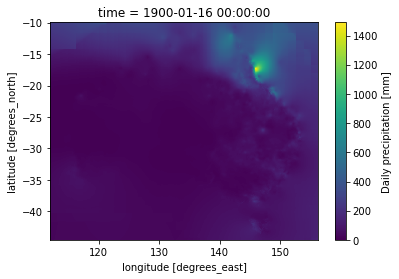

In [7]:
prXr.isel(time=0).plot()

So lets scale that:

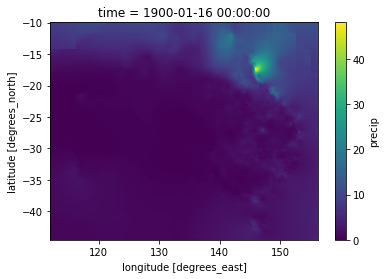

In [8]:
prXr=(prXr/prXr.time.dt.days_in_month)
prXr.name='precip'
prXr.isel(time=0).plot()

In [7]:
prXr

<xarray.DataArray 'precip' (time: 1445, lat: 691, lon: 886)>
dask.array<concatenate, shape=(1445, 691, 886), dtype=float32, chunksize=(12, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2020-05-16 00:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:           time: sum time: sum (interval : 1 day)
    units:                  mm
    long_name:              Daily precipitation
    standard_name:          lwe_thickness_of_precipitation_amount
    frequency:              monthly
    start_offset:           -24
    grid_mapping:           crs
    coverage_content_type:  physicalMeasurement
    valid_range:            [     0. 100000.]

# and temp

In [8]:
tPaths = !find /g/data/zv2/agcd/v1/tmax/mean/r005/01month

In [9]:
tXr=xarray.open_mfdataset(tPaths[1:], use_cftime=True).tmax

In [10]:
tXr

<xarray.DataArray 'tmax' (time: 1325, lat: 691, lon: 886)>
dask.array<concatenate, shape=(1325, 691, 886), dtype=float32, chunksize=(12, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1910-01-16 00:00:00 ... 2020-05-16 00:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:               time: maximum time: mean (interval : 1 day)
    units:                      degrees_Celsius
    analysis_version_number:    2.0
    long_name:                  Daily maximum air temperature
    standard_name:              air_temperature
    frequency:                  monthly
    length_scale_for_analysis:  350.0
    end_offset:                 24
    grid_mapping:               crs
    coverage_content_type:      physicalMeasurement
    valid_range:                [-100.  100.]

# Process them into anomalies, and calculate warm season avs

In [11]:
prTXr=xarray.merge([
    prXr,
    tXr
])

prTXr=to_365day_monthly(prTXr) #Use 365 calendar for consistency with everything else

In [12]:
#climatXr=prTXr.where(prTXr.time.dt.year<1930)
climatXr=prTXr

prTAnomsXr=prTXr.groupby('time.month')-climatXr.groupby('time.month').mean('time')
prTAnomsXr=prTAnomsXr.rename({'tmax':'tsAnom','precip':'precAnom'})

In [15]:
prTWarmSeasonXr=tp.averageForTimePeriod(prTAnomsXr)

In [36]:
prTWarmSeasonXr=prTWarmSeasonXr.chunk({'year':'auto','lat':691,'lon':100}) #chunk so there is only one chunk along the time axis

In [37]:
prTWarmSeasonXr

<xarray.Dataset>
Dimensions:   (lat: 691, lon: 886, year: 120)
Coordinates:
  * lat       (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon       (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * year      (year) int64 1900 1901 1902 1903 1904 ... 2015 2016 2017 2018 2019
Data variables:
    precAnom  (year, lat, lon) float64 dask.array<chunksize=(120, 691, 100), meta=np.ndarray>
    tsAnom    (year, lat, lon) float32 dask.array<chunksize=(120, 691, 100), meta=np.ndarray>

In [38]:
prTWarmSeasonXr.to_netcdf('results/observPrTmaxAnoms.nc')